<a href="https://colab.research.google.com/github/gongx030/DrImpute/blob/master/GM12878_0_010_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examine the sequence pattern 0f 1% down-sampled GM12878 dataset
by Wuming Gong


This analysis demonstrates the performance of VAE on recovering V-plot and predicting the nucleosome positions on down-sampled dataset.  We used the nucleosome predicted by NucleoATAC on the full GM12878 dataset as the ground truth.

In [75]:
start_time0 <- Sys.time()

### Install external packages

In [76]:
system('apt-get -q install libgsl-dev', intern = TRUE)

[1] "Reading package lists..."                                       
[2] "Building dependency tree..."                                    
[3] "Reading state information..."                                   
[4] "libgsl-dev is already the newest version (2.4+dfsg-6)."         
[5] "0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded."

In [77]:
system('apt-get install libcairo2-dev', intern = TRUE) # for Cairo package that is required by ComplexHeatmap package

[1] "Reading package lists..."                                         
[2] "Building dependency tree..."                                      
[3] "Reading state information..."                                     
[4] "libcairo2-dev is already the newest version (1.15.10-2ubuntu0.1)."
[5] "0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded."

## Install and load R packages

In [78]:
required_packages <- c(
    'devtools', 'BiocManager', 
    'reshape2', 'ggplot2', 'umap', 'ggrepel', 'FNN', 'igraph', 'dendsort', 
    'BSgenome.Hsapiens.UCSC.hg19', 'TxDb.Hsapiens.UCSC.hg19.knownGene',
    'gsl', 'DirichletMultinomial', 'motifmatchr', 'chromVAR'
)

In [79]:
missing_packages <- required_packages[!required_packages %in% rownames(installed.packages())]
if (length(missing_packages) > 0){
    BiocManager::install(missing_packages)
}

In [80]:
library(devtools)

### Install the `seatac` package

In [81]:
install_github('gongx030/seatac', auth_token = '651f209818e0b5ec16daccbf1ded85343f1766cd', force = TRUE, quiet = FALSE)
reload(pkgload::inst("seatac"))


✔  checking for file ‘/tmp/RtmpIBIO4P/remotes81164eaf06a/gongx030-seatac-e32acf4a563c761df1e89b92b35a7f38b2a5d98d/DESCRIPTION’ (957ms)
─  preparing ‘seatac’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘seatac_0.3.17.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Reloading attached seatac


Attaching package: ‘seatac’


The following object is masked from ‘package:motifmatchr’:

    match_motifs


The following object is masked from ‘package:S4Vectors’:

    decode


The following object is masked from ‘package:tfdatasets’:

    fit


The following object is masked from ‘package:stats’:

    predict




### Install R packages that are not available on CRAN or Bioc

In [82]:
if (!require('chromVARmotifs'))
  devtools::install_github("GreenleafLab/chromVARmotifs")

In [83]:
library(tfdatasets)
library(dplyr)
library(seatac)
library(reshape2) # melt
library(ggplot2)
library(gplots)
library(SummarizedExperiment)
library(BSgenome.Hsapiens.UCSC.hg19)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(matrixStats)
library(rtracklayer)
library(motifmatchr)
library(chromVARmotifs)

## Load a down-sampled GM12878 ATAC-seq data
This dataset contains 0.1% of randomly down-sampled reads from the full ATAC-seq data

In [84]:
d <- data.frame(
  remote_bam_file = sprintf('https://s3.msi.umn.edu/gongx030/projects/tfnet_project/data/dataset=GM12878_seed=%d_pct=0.0100.bam', 1:20)
) %>%
  mutate(remote_bed_file = gsub('.bam', '.bed', remote_bam_file)) %>%
  mutate(local_bam_file = gsub('https://s3.msi.umn.edu/', './', remote_bam_file)) %>%
  mutate(local_bed_file = gsub('https://s3.msi.umn.edu/', './', remote_bed_file)) %>%
  mutate(remote_seatac_file = gsub('.bam', '.seatac.bw', remote_bam_file)) %>%
  mutate(local_seatac_file = gsub('https://s3.msi.umn.edu/', './', remote_seatac_file)) %>%
  mutate(remote_nucleoatac_file = gsub('.bam', '.nucleoatac_signal.smooth.bw', remote_bam_file)) %>%
  mutate(local_nucleoatac_file = gsub('https://s3.msi.umn.edu/', './', remote_nucleoatac_file))

In [93]:
for (i in 1:nrow(d)){
  system(sprintf('wget -x -c -nH %s', d[i, 'remote_bam_file']))
  system(sprintf('wget -x -c -nH %s', d[i, 'remote_bed_file']))
  system(sprintf('wget -x -c -nH %s', d[i, 'remote_seatac_file']))
  system(sprintf('wget -x -c -nH %s', d[i, 'remote_nucleoatac_file']))
}

In [94]:
message(sprintf('all BAM files: %s', d[, 'local_bam_file'] %>% file.exists() %>% all()))
message(sprintf('all SeATAC files: %s', d[, 'local_seatac_file'] %>% file.exists() %>% all()))
message(sprintf('all NucleoATAC files: %s', d[, 'local_nucleoatac_file'] %>% file.exists() %>% all()))

all BAM files: TRUE

all SeATAC files: TRUE

all NucleoATAC files: TRUE



In [12]:
#remote_bam_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells.bam'
#local_bam_file <- gsub('https://s3.msi.umn.edu/', './', remote_bam_file)
#local_bed_file <- gsub('https://s3.msi.umn.edu/', './', remote_bed_file)
#system(sprintf('wget -x -c -nH %s', remote_bam_file))
#system(sprintf('wget -x -c -nH %s', remote_bed_file))

In [95]:
blacklist_file <- 'https://s3.msi.umn.edu/gongx030/datasets/datasets=blacklists_version=20190827a/hg19.blacklist.bed.gz'
blacklist <- blacklist_file %>%
  url() %>%
  gzcon() %>%
  readLines() %>%
  textConnection() %>%
  read.table(header = TRUE, sep = '\t')
blacklist <- GRanges(seqnames = blacklist[, 1], range = IRanges(blacklist[, 2], blacklist[, 3]))

In [96]:
peak_size <- 250 # the ATAC-seq peaks
window_size <- 1000 # the vplot window size
remote_bed_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_50k_cells_summits.bed'
gr <- read.table(remote_bed_file, header = FALSE, sep = '\t')
gr <- GRanges(seqnames = gr[, 1], range = IRanges(gr[, 2], gr[, 3]))
gr <- gr %>% resize(width = window_size, fix = 'center')
gr <- gr[!gr %over% blacklist]
gr <- gr[!seqnames(gr) %in% c('chrM', 'chrY')]

In [97]:
data('homer_pwms')
names(homer_pwms)[grep('CTCF', names(homer_pwms))]

[1] "BORIS(Zf)/K562-CTCFL-ChIP-Seq(GSE32465)/Homer"                     
[2] "CTCF(Zf)/CD4+-CTCF-ChIP-Seq(Barski_et_al.)/Homer"                  
[3] "CTCF-SatelliteElement(Zf?)/CD4+-CTCF-ChIP-Seq(Barski_et_al.)/Homer"

## Find the CTCF binding sites

In [98]:
#peak_size <- window_size / 2
peak_size <- 500L
motif_ix <- matchMotifs(homer_pwms['CTCF(Zf)/CD4+-CTCF-ChIP-Seq(Barski_et_al.)/Homer'], resize(gr, width = peak_size * 2, fix = 'center'), genome = BSgenome.Hsapiens.UCSC.hg19, out = 'position')
peaks <- unlist(motif_ix)

In [99]:
peaks <- peaks %>% 
  resize(width = peak_size, fix = 'center')

## Read NucleoATAC results on full GM12878 data
These results will be used as the `ground truth` nucleosomes

In [100]:
nucleoatac_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Buenrostro_version=20170721a/GM12878_20170314b.nucleoatac_signal.smooth.bw'
system(sprintf('wget -x -c -nH %s', nucleoatac_file))
local_nucleoatac_file <- gsub('https://s3.msi.umn.edu/', './', nucleoatac_file)

In [101]:
cvg <- rtracklayer::import(local_nucleoatac_file, granges(peaks), format = 'BigWig', as = 'RleList')
full_nucleoatac <- cvg[peaks] %>% as.matrix()

## Plot of nucleosomes surrounding the CTCF binding sites

[Lai et al.](https://www.nature.com/articles/s41586-018-0567-3) in their scMNase-seq paper showed an oscillation of observed nucleosome surrounding the CTCF binding site.  
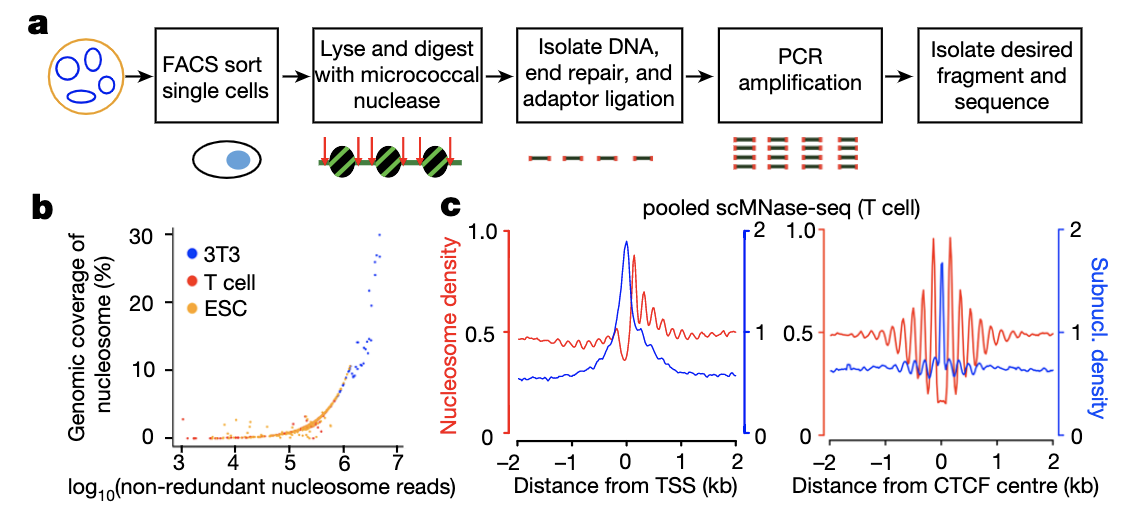

Here we examine whether we can observe such oscillation in the SeATAC prediction.  However, it appears that the pattern is similar to the prediction from NucleoATAC.

Aggregated nucleosome estimations from down-sampled ATAC-seq

In [102]:
y_seatac <- lapply(1:nrow(d), function(i){
  cvg <- rtracklayer::import(d[i, 'local_seatac_file'], granges(peaks), format = 'BigWig', as = 'RleList')
  xi <- cvg[peaks] %>% as.matrix()
  xi[rowSums(xi) > 0, ] 
})

Aggregated nucleosome estimations from down-sampled ATAC-seq by NucleoATAC

In [103]:
y_nucleoatac <- lapply(1:nrow(d), function(i){
  cvg <- rtracklayer::import(d[i, 'local_nucleoatac_file'], granges(peaks), format = 'BigWig', as = 'RleList')
  xi <- cvg[peaks] %>% as.matrix()
  xi[rowSums(xi) > 0, ] 
})

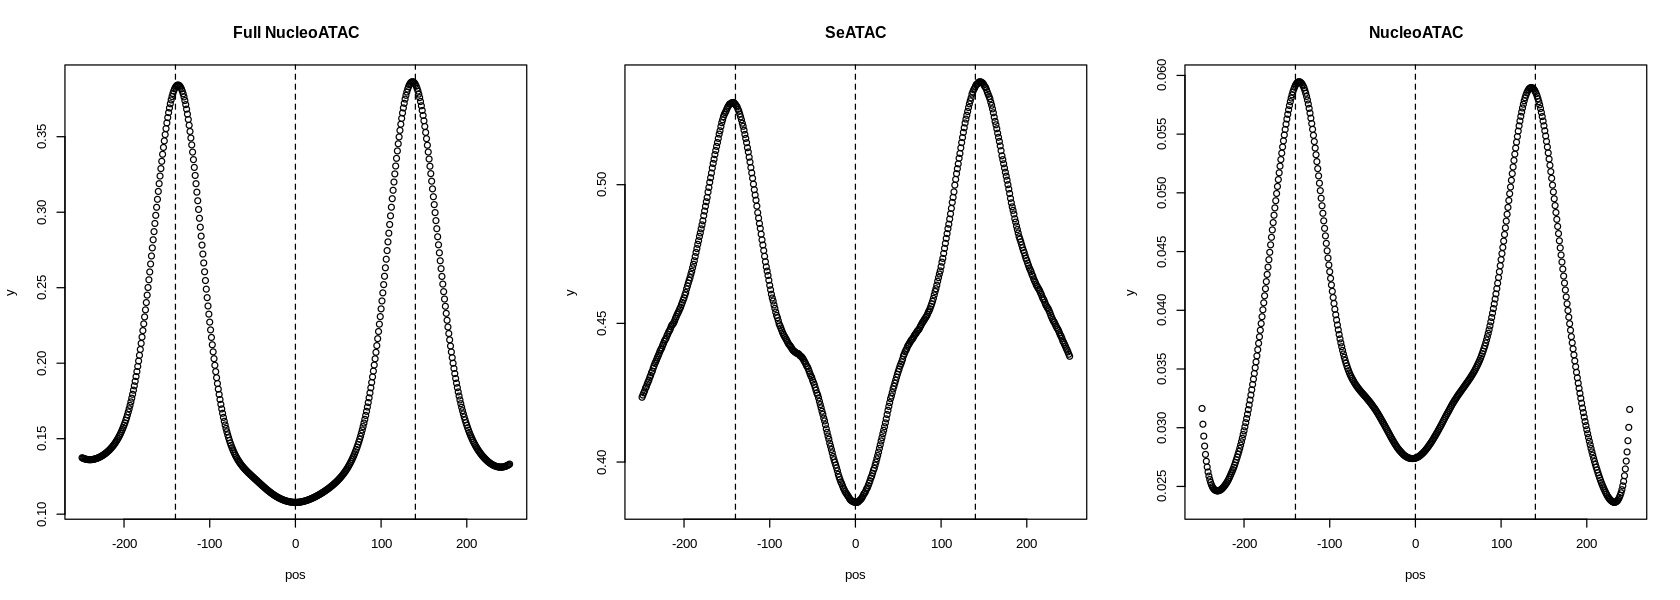

In [104]:
options(repr.plot.width = 14, repr.plot.height = 5)
par(mfrow = c(1, 3))
pos <- 1:(peak_size) - peak_size/ 2
y <- full_nucleoatac %>% scale01() %>% colMeans() 
plot(x = pos, y = y, main = 'Full NucleoATAC')
abline(v = c(-140, 0, 140), lty = 2)
y <- do.call('rbind', y_seatac) %>% scale01() %>% colMeans() 
plot(x = pos, y = y, main = 'SeATAC')
abline(v = c(-140, 0, 140), lty = 2)
y <- do.call('rbind', y_nucleoatac) %>% scale01() %>% colMeans() 
plot(x = pos, y = y, main = 'NucleoATAC')
abline(v = c(-140, 0, 140), lty = 2)


## Plot of nucleosomes surrounding the transcription start sites


In [105]:
peaks <- promoters(TxDb.Hsapiens.UCSC.hg19.knownGene, upstream = peak_size / 2, downstream = peak_size / 2)
peaks

GRanges object with 82960 ranges and 2 metadata columns:
                   seqnames        ranges strand |     tx_id     tx_name
                      <Rle>     <IRanges>  <Rle> | <integer> <character>
  uc001aaa.3           chr1   11624-12123      + |         1  uc001aaa.3
  uc010nxq.1           chr1   11624-12123      + |         2  uc010nxq.1
  uc010nxr.1           chr1   11624-12123      + |         3  uc010nxr.1
  uc001aal.1           chr1   68841-69340      + |         4  uc001aal.1
  uc001aaq.2           chr1 320834-321333      + |         5  uc001aaq.2
         ...            ...           ...    ... .       ...         ...
  uc011mgu.1 chrUn_gl000237     2437-2936      - |     82956  uc011mgu.1
  uc011mgv.2 chrUn_gl000241   36626-37125      - |     82957  uc011mgv.2
  uc011mgw.1 chrUn_gl000243   11251-11750      + |     82958  uc011mgw.1
  uc022brq.1 chrUn_gl000243   13358-13857      + |     82959  uc022brq.1
  uc022brr.1 chrUn_gl000247     5567-6066      - |     82960  uc022

In [106]:
cvg <- rtracklayer::import(local_nucleoatac_file, granges(peaks), format = 'BigWig', as = 'RleList')
full_nucleoatac <- cvg[peaks] %>% as.matrix()
is_minus <- as.logical(strand(peaks) == '-')
full_nucleoatac[is_minus, ] <- full_nucleoatac[is_minus, peak_size:1]

Aggregated nucleosome estimations from down-sampled ATAC-seq

In [ ]:
y_seatac <- lapply(1:nrow(d), function(i){
  cvg <- rtracklayer::import(d[i, 'local_seatac_file'], granges(peaks), format = 'BigWig', as = 'RleList')
  xi <- cvg[peaks] %>% as.matrix()
  xi[is_minus, ] <- xi[is_minus, peak_size:1]
  xi[rowSums(xi) > 0, ] 
})

Aggregated nucleosome estimations from down-sampled ATAC-seq by NucleoATAC

In [ ]:
y_nucleoatac <- lapply(1:nrow(d), function(i){
  cvg <- rtracklayer::import(d[i, 'local_nucleoatac_file'], granges(peaks), format = 'BigWig', as = 'RleList')
  xi <- cvg[peaks] %>% as.matrix()
  xi[is_minus, ] <- xi[is_minus, peak_size:1]
  xi[rowSums(xi) > 0, ] 
})

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5)
pos <- 1:(peak_size) - peak_size/ 2
y <- full_nucleoatac %>% colMeans() 
y <- (y - min(y)) / (max(y) - min(y))
plot(x = pos, y = y, type = 'l', col = 'blue', xaxs="i", lwd = 4, ylim = c(0, 1))
y <- do.call('rbind', y_nucleoatac) %>% colMeans() 
y <- (y - min(y)) / (max(y) - min(y))
lines(x = pos, y = y, lwd = 4, col = 'black')
y <- do.call('rbind', y_seatac) %>% colMeans() 
y <- (y - min(y)) / (max(y) - min(y))
lines(x = pos, y = y, lwd = 4, col = '#E69F00')

SeATAC has better performance on recovering the nucleosome positions surrounding the transcription start sites, than NucleoATAC, on down-sampled ATAC-seq data.  This result can be shown in the manuscript.  We will demonstrate similar thing for scATAC-seq data.

## Read MNase on GM12878

In [ ]:
remote_mnase_file <- 'https://s3.msi.umn.edu/gongx030/datasets/dataset=Kundajie_version=20190802a/GSM920558_hg19_wgEncodeSydhNsomeGm12878Sig.bw'
system(sprintf('wget -x -c -nH %s', remote_mnase_file))
local_mnase_file <- gsub('https://s3.msi.umn.edu/', './', remote_mnase_file)

These lines crash on Colab due to the RAM limits.

In [ ]:
#cvg <- rtracklayer::import(local_mnase_file, granges(x), format = 'BigWig', as = 'RleList')
#mnase <- cvg[granges(x)] %>% as.matrix()

## Loss between observed nucleosome and the nucleosome predicted by NucleoATAC and SeATAC

In [ ]:
nucleoatac <- nucleoatac %>% scale01()
full_nucleoatac <- full_nucleoatac %>% scale01()
nucleosome <- nucleosome %>% scale01()

In [ ]:
bce <- tf$keras$losses$BinaryCrossentropy(reduction = 'none')
bce_nucleoatac <- bce(full_nucleoatac, nucleoatac) %>% as.numeric()
bce_vae <- bce(full_nucleoatac, nucleosome) %>% as.numeric()

## Plot the number of reads per block vs. cross binary entropy loss

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

`summarise()` regrouping output by 'n' (override with `.groups` argument)



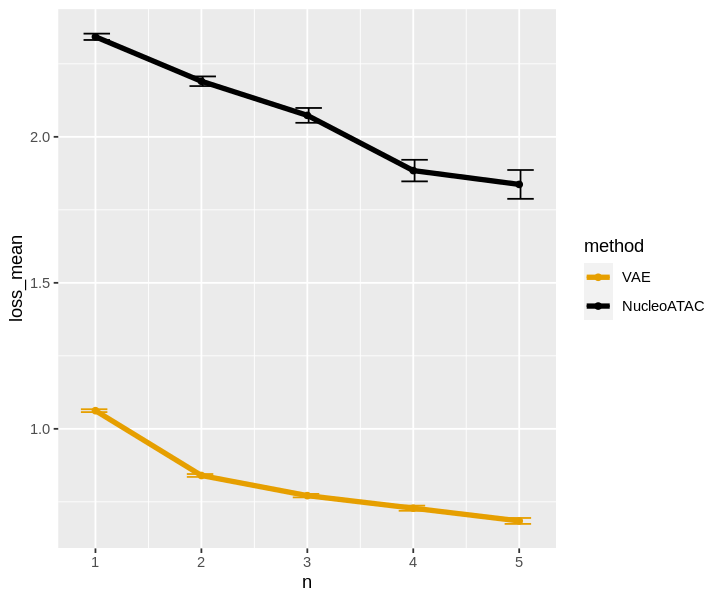

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)
data.frame(
  n = rowSums(assays(x)$counts),
  loss_nucleosome = bce_vae,
  loss_nucleoatac = bce_nucleoatac
) %>%
  melt(
    measure.vars = c('loss_nucleosome', 'loss_nucleoatac'), 
    value.name = 'loss', 
    variable.name = 'method'
  ) %>%
  mutate(method = factor(method, c('loss_nucleosome', 'loss_nucleoatac'), c('VAE', 'NucleoATAC'))) %>% 
  filter(n >= 1 & n <= 5) %>%
  group_by(n, method) %>%
  summarize(
    loss_mean = mean(loss),
    loss_se = sd(loss) / sqrt(length(loss))
  ) %>% 
  ggplot(aes(x = n, y = loss_mean, color = method, group = method)) +
    geom_point() +
    geom_line(size = 1.5) +
    geom_errorbar(aes(ymin = loss_mean - loss_se, ymax = loss_mean + loss_se), width = .5, position = position_dodge(0.05)) +
    scale_color_manual(values=c(NucleoATAC = "black", VAE = "#E69F00")) +
    scale_x_continuous(breaks = c(1:5))

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

`summarise()` ungrouping output (override with `.groups` argument)



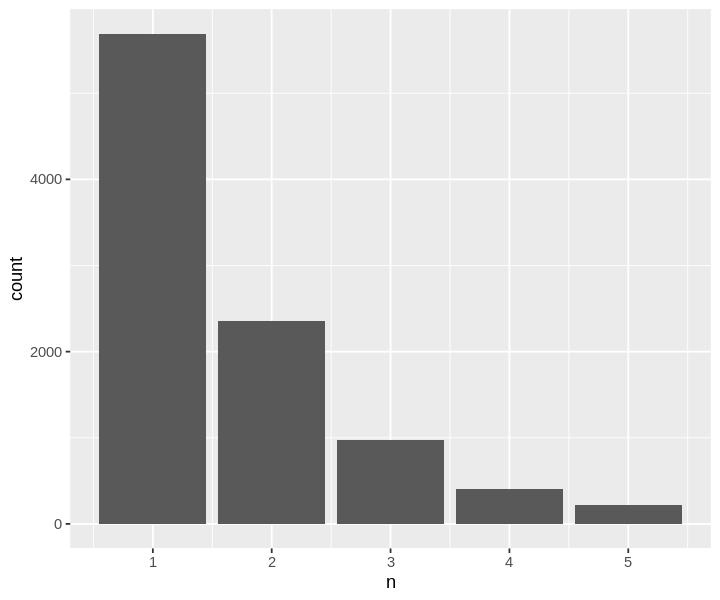

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 5)
data.frame(
  n = rowSums(assays(x)$counts)
) %>% 
  filter(n >= 1 & n <= 5) %>%
  group_by(n) %>%
  summarize(count = n()) %>%
  ggplot(aes(x = n, y = count)) +
    geom_bar(stat="identity", position=position_dodge()) +
    scale_x_continuous(breaks = c(1:5))

Mean nucleosome profiles

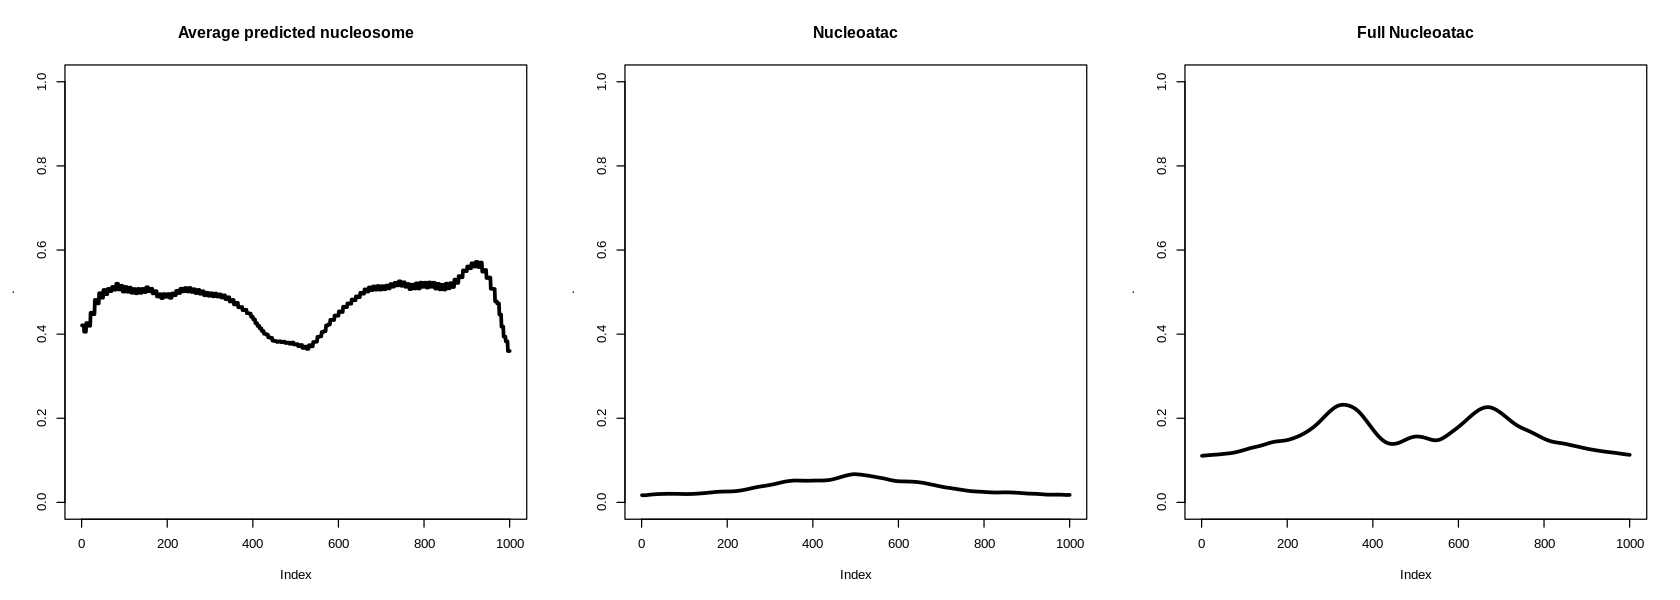

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 5)
par(mfrow = c(1, 3))
nucleosome %>% colMeans() %>% plot(type = 'l', lwd = 3, ylim = c(0, 1), main = 'Average predicted nucleosome')
nucleoatac %>% colMeans() %>% plot(type = 'l', lwd = 3, ylim = c(0, 1), main = 'Nucleoatac')
full_nucleoatac %>% colMeans() %>% plot(type = 'l', lwd = 3, ylim = c(0, 1), main = 'Full Nucleoatac')

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



[1] 3129


dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



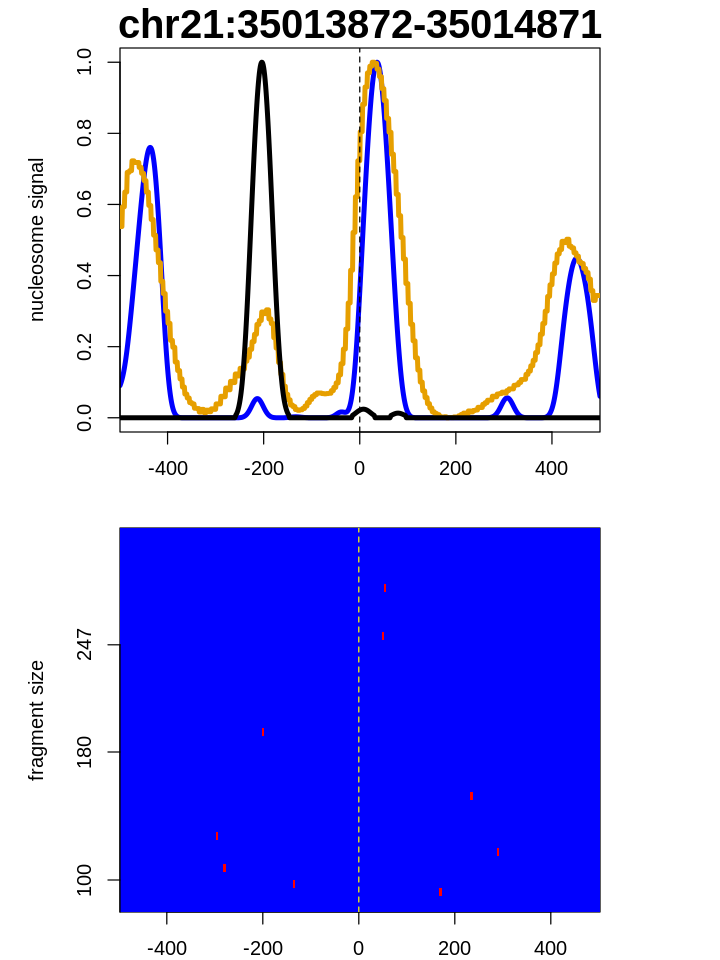

In [ ]:
i <-  sample(which(rowSums(assays(x)$counts) > 5), 1)
i <- 3129
print(i)
options(repr.plot.width = 6, repr.plot.height = 8)
par(mfrow = c(2, 1), mar = c(2, 5, 2, 5))

y_observed <- full_nucleoatac[i, ]
y_nucleoatac <- nucleoatac[i, ]
y_vae <- nucleosome[i, ]
pos <- 1:x@window_size - x@window_size / 2

plot(pos, y_observed, type = 'l', main = sprintf('%s:%d-%d', seqnames(x)[i], start(x)[i], end(x)[i]), lwd = 4, xlab = '', ylab = 'nucleosome signal', col = 'blue', xaxs="i", cex.main = 2, ylim = c(0, 1))
points(pos, y_vae, type = 'l', col = '#E69F00', lwd = 4)
points(pos, y_nucleoatac, type = 'l', col = 'black', lwd = 4)
abline(v = 0, lty = 2, col = 'black')

vplot(x[i], 'counts')

## Heatmap of ground truth nucleosome, predicted nucleosome by VAE, and by NucleoATAC

Split blocks into two groups according to the mean nucleosome signal predicted by NucleoATAC on the full dataset:
* nucleosome (nuc > 0.5)
* nucleosome free (nuc < 0.1)

In [ ]:
pos <- 1:x@window_size - x@window_size / 2
centers <- which(pos >= -50 & pos <= 50)
center_nucleosome <- full_nucleoatac[, centers] %>% 
  rowMeans()
cluster <- cut(
  center_nucleosome, c(0, 0.1, 0.5, 100),
  include.lowest = TRUE
) %>%
  factor(label = c('nfr', 'between', 'nucleosome'))
cluster %>% table()

.
       nfr    between nucleosome 
      5800       3401        799 

## Plot the number of blocks which BCE from VAE or NucleoATAC is below or above a threshold

BCE cutoff for subsetting blocks: 1.331

% of blocks that are selected: 77.800%



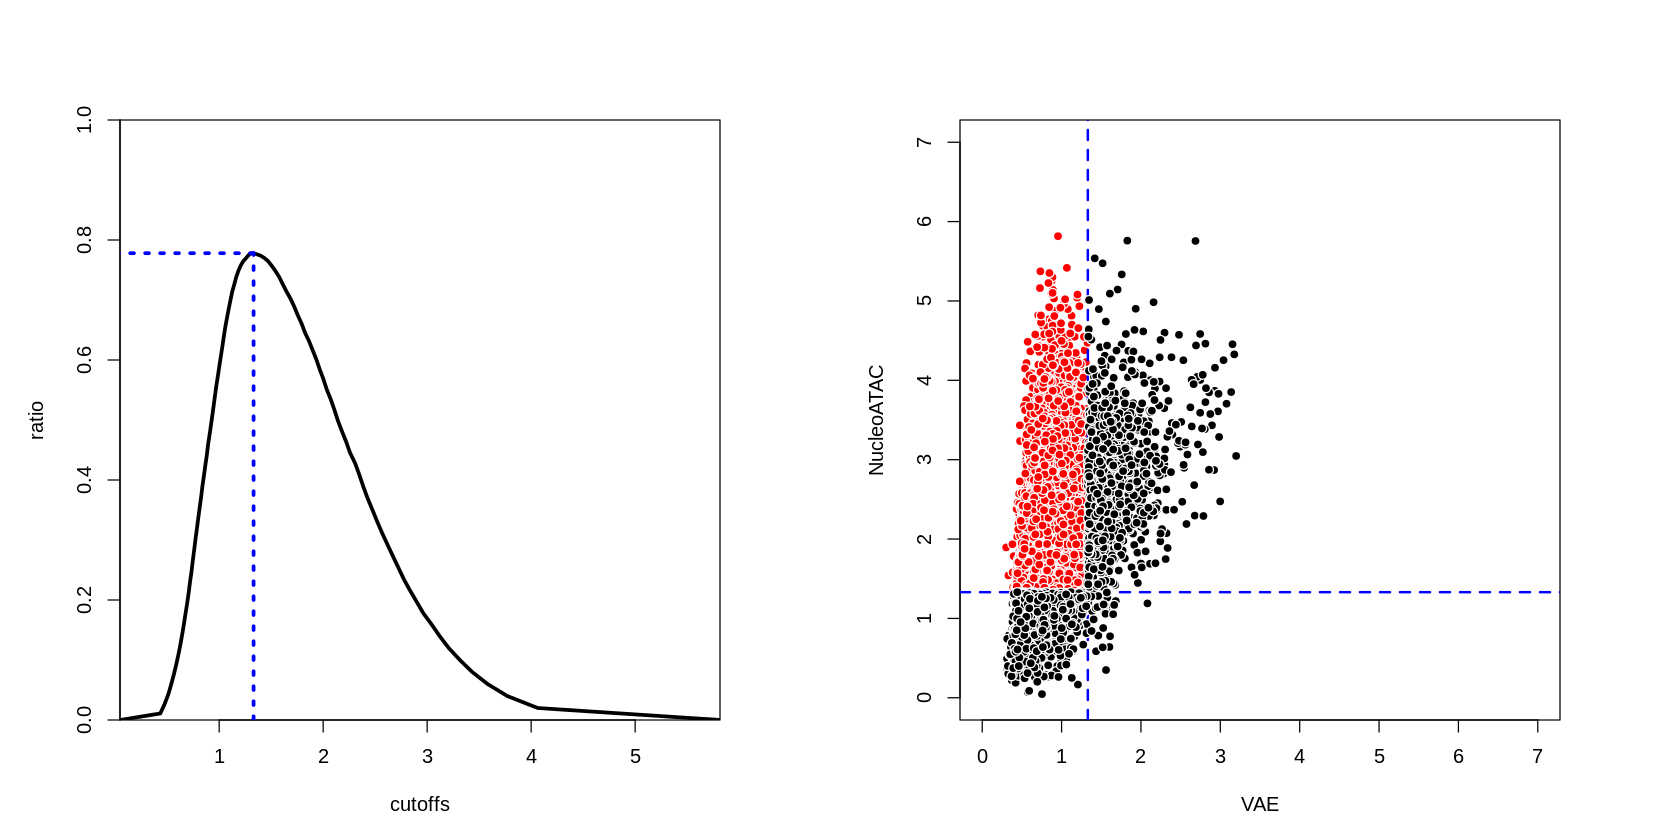

In [ ]:
cutoffs <- c(bce_vae, bce_nucleoatac) %>% quantile(seq(0, 1, by = 0.01))
ratio <- sapply(cutoffs, function(t) sum(bce_vae < t & bce_nucleoatac > t) / length(x))
options(repr.plot.width =14, repr.plot.height = 7)
par(mar = c(5, 5, 5, 5), mfrow = c(1, 2))
plot(cutoffs, ratio, type = 'l', xaxs = 'i', yaxs = 'i', lwd = 3, ylim = c(0, 1))
cutoffs1 <- cutoffs[which.max(ratio)]
ratio1 <- ratio[which.max(ratio)]
segments(0, ratio1, cutoffs1, ratio1, lwd = 3, col = 'blue', lty = 3)
segments(cutoffs1, 0, cutoffs1, ratio1, lwd = 3, col = 'blue', lty = 3)

message(sprintf('BCE cutoff for subsetting blocks: %.3f', cutoffs1))
message(sprintf('%% of blocks that are selected: %.3f%%', ratio1 * 100))

include <- bce_vae < cutoffs1 & bce_nucleoatac > cutoffs1
df <- data.frame(
  vae = bce_vae,
  nucleoatac = bce_nucleoatac,
  include = include
)
plot(nucleoatac ~ vae, df[include, ], xlim = c(0, 7), ylim = c(0, 7), xlab = 'VAE', ylab = 'NucleoATAC', pch = 21, col = 'white', bg = 'red')
abline(h = cutoffs1, v = cutoffs1, lwd = 2, lty = 2, col = 'blue')
points(nucleoatac ~ vae, df[!include, ], pch = 21, col = 'white', bg = 'black')

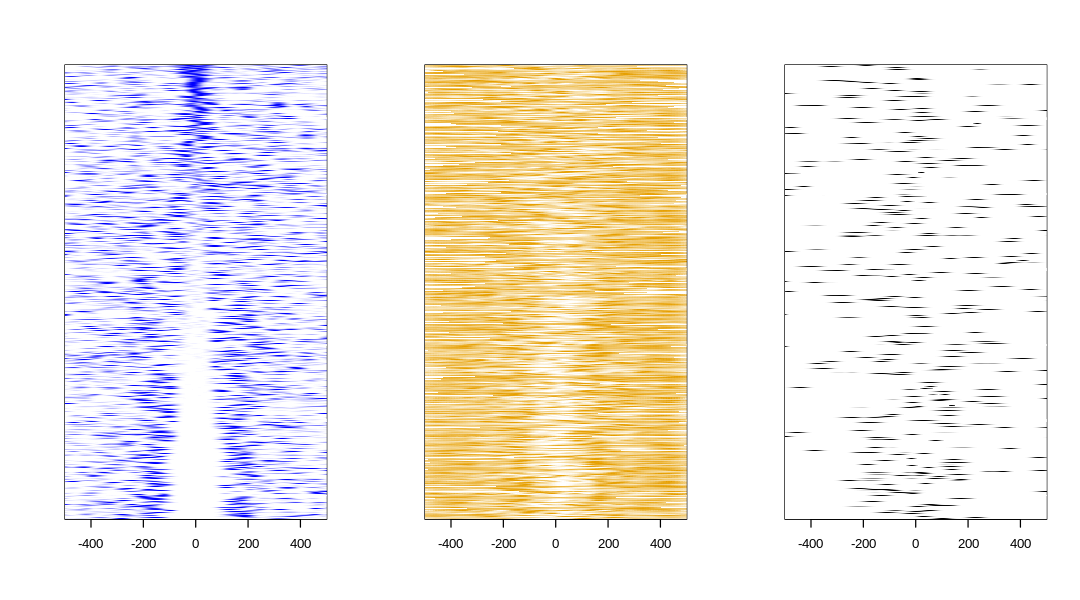

In [ ]:
h <- order(center_nucleosome) # order the blocks according to the center nuclsomee censit

options(repr.plot.width = 9, repr.plot.height = 5)
par(mfrow = c(1, 3))
pos <- 1:x@window_size - x@window_size / 2
z <- full_nucleoatac[h, ] %>% t()
image(x = pos, y = 1:length(x), z, col = colorpanel(100, low = 'white', high = 'blue'), yaxt = 'n', xlab = '', ylab = '')
z <- nucleosome[h, ] %>% t()
image(x = pos, y = 1:length(x), z, col = colorpanel(100, low = 'white', high = '#E69F00'), yaxt = 'n', xlab = '', ylab = '')
z <- nucleoatac[h, ]  %>% t()
image(x = pos, y = 1:length(x), z, col = colorpanel(100, low = 'white', high = 'black'), yaxt = 'n', xlab = '', ylab = '')


dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)

dimnames(.) <- NULL:  translated to 
dimnames(.) <- list(NULL,NULL)  <==>  unname(.)



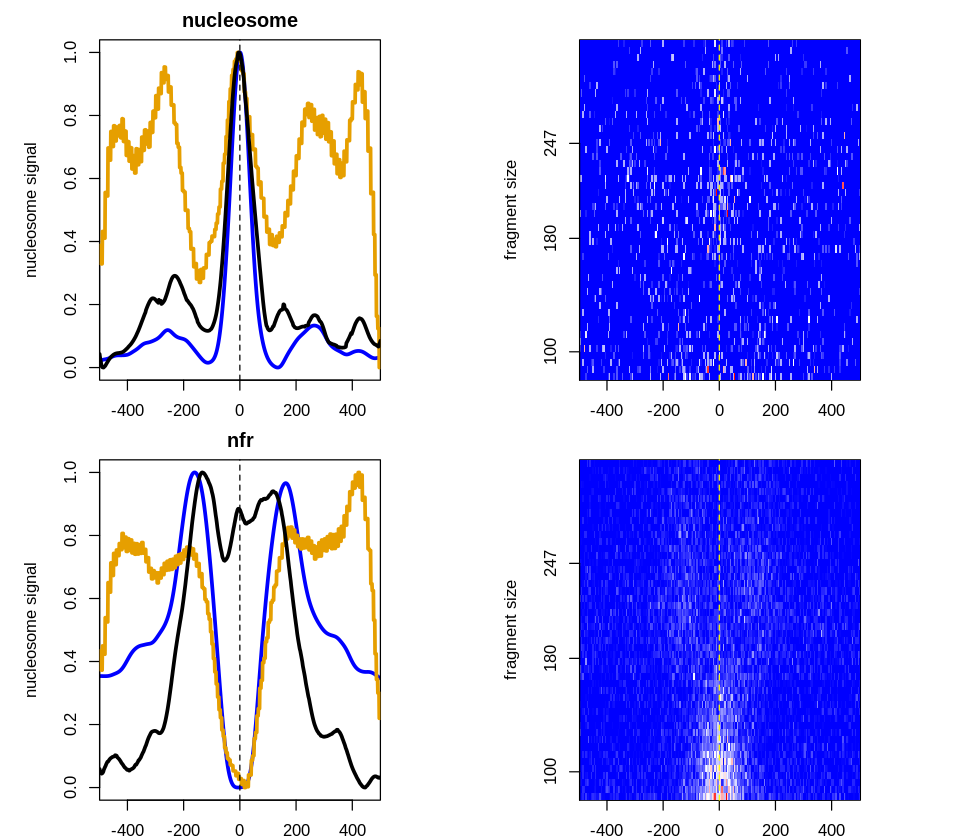

In [ ]:
par(mfrow = c(2, 2), mar = c(2, 5, 2, 5))
options(repr.plot.width = 8, repr.plot.height = 7)
for (i in c('nucleosome', 'nfr')){
  h <- cluster == i

  y_observed <- full_nucleoatac[h, ] %>% colMeans() 
  y_vae <- nucleosome[h, ] %>% colMeans()
  y_nucleoatac <- nucleoatac[h, ] %>% colMeans()

  y_observed <- (y_observed - min(y_observed)) / (max(y_observed) - min(y_observed))
  y_vae <- (y_vae - min(y_vae)) / (max(y_vae) - min(y_vae))
  y_nucleoatac <- (y_nucleoatac - min(y_nucleoatac)) / (max(y_nucleoatac) - min(y_nucleoatac))

  pos <- 1:x@window_size - x@window_size / 2
  plot(pos, y_observed, type = 'l', lwd = 3, xlab = '', ylab = 'nucleosome signal', col = 'blue', xaxs="i", ylim = c(0, 1), main = i)
  points(pos, y_vae, type = 'l', lwd = 3, col = '#E69F00', xaxs="i")
  points(pos, y_nucleoatac, type = 'l', lwd = 3, col = 'black', xaxs="i")
  abline(v = 0, lty = 2, col = 'black')

  vplot(x[h])
}

In [ ]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] seatac_0.3.16                     BSgenome.Hsapiens.UCSC.hg19_1.4.3
 [3] BSgenome_1.58.0                   rtracklayer_1.50.0               
 [5] Biostrings_2.58.0                 XVector_0.30.0                   
 [7] SummarizedExperiment_1

In [ ]:
Sys.time() - start_time0

Time difference of 5.523923 mins